<a href="https://colab.research.google.com/github/Deolinda1506/carotid-imt-segmentation-ml/blob/main/notebooks/Carotid_Ultrasound_IMT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Overview

This notebook details an end-to-end Machine Learning project focused on carotid artery ultrasound image segmentation, following a structured ML Track rubric. The primary goal is to segment the Common Carotid Artery (CCA) from ultrasound images from the Momot (2022) dataset and measure the Intima-Media Thickness (IMT).

Key steps and achievements include:

1.  **Data Visualization and Data Engineering**:
    *   Dataset loading and initial exploration.
    *   Visualization of raw image pixel intensity histograms to demonstrate speckle noise.
    *   Implementation and visualization of Contrast Limited Adaptive Histogram Equalization (CLAHE) for image preprocessing to enhance clarity.
    *   Definition of a custom `UltrasoundDataset` and creation of data loaders for training, validation, and testing.

2.  **Model Architecture (CNN baseline vs ViT+MAE)**:
    *   **U-Net Baseline**: Implemented a standard U-Net architecture, defining its encoder-decoder blocks with double convolutions, batch normalization, and ReLU activations.
    *   **Vision Transformer (ViT)**: Implemented a simplified Vision Transformer architecture with `PatchEmbedding` and `TransformerBlock` for segmentation, demonstrating an alternative to CNNs for global feature capture.

3.  **Initial Performance Metrics (DSC, MAD, F1)**:
    *   Developed functions for evaluating segmentation performance using **Dice Coefficient**, **F1-Score**, and **Mean Absolute Error (MAE)** for Intima-Media Thickness (IMT).
    *   Defined a `pixel_to_mm_ratio` for converting pixel measurements to millimeters for the IMT metric.

4.  **Training and Evaluation**:
    *   Set up and executed training and evaluation loops for both the U-Net and Vision Transformer models, utilizing mixed-precision training for efficiency.
    *   Tracked and reported training and validation losses, Dice Coefficient, F1-Score, and IMT MAE over multiple epochs.
    *   Compared the performance of both models, with the Vision Transformer consistently outperforming the U-Net across all metrics, indicating its superior capability for this segmentation task.

Overall, the notebook provides a comprehensive workflow from data preparation to model training and evaluation, concluding with a robust Vision Transformer model for carotid artery segmentation.

In [74]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [75]:
from pathlib import Path
from typing import Optional, Dict, Any, List

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Foundation-model-compatible normalization (ImageNet-style)
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

Using device: cuda


In [76]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
!unzip -o "/content/drive/MyDrive/Common Carotid Artery Ultrasound Images.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/Common Carotid Artery Ultrasound Images.zip
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1069.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1080.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1108.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1092.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1128.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1165.png  
  inflating: /content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1157.png  
  inflating: /content/data/Common Carotid Artery

In [78]:
import torchvision.transforms.functional as TF # Import functional transforms for consistent application

IMG_DIR = Path('/content/data/Common Carotid Artery Ultrasound Images/US images/')
MASK_DIR = Path('/content/data/Common Carotid Artery Ultrasound Images/Expert mask images/')

class UltrasoundDataset(Dataset):
    def __init__(self, img_dir: Path, mask_dir: Path, transforms: Optional[Any] = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms # This will be our joint transform object
        self.img_files = sorted(list(img_dir.glob('*.png')))
        self.mask_files = sorted(list(mask_dir.glob('*.png')))

        print(f"Found {len(self.img_files)} image files in {img_dir}")
        print(f"Found {len(self.mask_files)} mask files in {mask_dir}")
        if self.img_files:
            print(f"Sample image files: {self.img_files[:5]}")
        if self.mask_files:
            print(f"Sample mask files: {self.mask_files[:5]}")

        assert len(self.img_files) == len(self.mask_files), "Number of images and masks must be equal."

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # L for grayscale mask

        if self.transforms:
            image, mask = self.transforms(image, mask)

        # Convert mask to binary (0 or 1)
        mask = (mask > 0).float()

        return {"image": image, "mask": mask}

# Define joint transforms for train and eval
class JointTransforms:
    def __init__(self, img_size, is_train=False):
        self.img_size = img_size
        self.is_train = is_train
        self.normalize = T.Normalize(mean=IMG_MEAN, std=IMG_STD)

    def __call__(self, image: Image.Image, mask: Image.Image):
        # Resize first (consistent for all)
        image = TF.resize(image, (self.img_size, self.img_size), interpolation=T.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (self.img_size, self.img_size), interpolation=T.InterpolationMode.NEAREST)

        if self.is_train:
            # Random Horizontal Flip
            if torch.rand(1) < 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random Rotation (up to 10 degrees)
            angle = T.RandomRotation.get_params([-10, 10])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST)

            # ColorJitter (only on image)
            image = T.ColorJitter(brightness=0.2, contrast=0.2)(image)

        # Convert to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        # Normalize image
        image = self.normalize(image)

        return image, mask

# Define IMG_SIZE outside the class definition, as it's already done above
# IMG_SIZE = 128

# Instantiate the dataset
# Split dataset into training, validation, and test sets based on indices
# Create a dummy dataset just to get the full list of files and then split indices
full_dataset_indices_source = UltrasoundDataset(IMG_DIR, MASK_DIR)
train_size = int(0.7 * len(full_dataset_indices_source))
val_size = int(0.15 * len(full_dataset_indices_source))
test_size = len(full_dataset_indices_source) - train_size - val_size

# Use random_split on a range of indices to get the splits
all_indices = list(range(len(full_dataset_indices_source)))

# Manual random split to get indices (random_split expects a Dataset, not just indices)
# We will use random_split to get the Subset objects, and then adapt.
# For simplicity and to correctly apply transforms per split, we'll re-instantiate datasets.

dataset_for_split = UltrasoundDataset(IMG_DIR, MASK_DIR) # Dataset to get indices from
train_subset_indices, val_subset_indices, test_subset_indices = random_split(dataset_for_split, [train_size, val_size, test_size])

# Now create actual datasets with their respective transforms
# train_dataset will use augmentation, val_dataset and test_dataset will not.

train_dataset = UltrasoundDataset(IMG_DIR, MASK_DIR, transforms=JointTransforms(IMG_SIZE, is_train=True))
train_dataset = torch.utils.data.Subset(train_dataset, train_subset_indices.indices) # Wrap with Subset to use correct indices

val_dataset = UltrasoundDataset(IMG_DIR, MASK_DIR, transforms=JointTransforms(IMG_SIZE, is_train=False))
val_dataset = torch.utils.data.Subset(val_dataset, val_subset_indices.indices)

test_dataset = UltrasoundDataset(IMG_DIR, MASK_DIR, transforms=JointTransforms(IMG_SIZE, is_train=False))
test_dataset = torch.utils.data.Subset(test_dataset, test_subset_indices.indices)

# Create DataLoaders
BATCH_SIZE = 4 # Reduced from 8 to 4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total dataset size: {len(full_dataset_indices_source)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataloader.dataset)}") # Use .dataset to get original dataset length from random_split

# Verify a batch
for i, batch in enumerate(train_dataloader):
    print(f"Batch {i+1} - Image shape: {batch['image'].shape}, Mask shape: {batch['mask'].shape}")
    if i == 0:
        break

Found 1100 image files in /content/data/Common Carotid Artery Ultrasound Images/US images
Found 1100 mask files in /content/data/Common Carotid Artery Ultrasound Images/Expert mask images
Sample image files: [PosixPath('/content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1069.png'), PosixPath('/content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1080.png'), PosixPath('/content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1092.png'), PosixPath('/content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1108.png'), PosixPath('/content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1128.png')]
Sample mask files: [PosixPath('/content/data/Common Carotid Artery Ultrasound Images/Expert mask images/202201121748100022VAS_slice_1069.png'), PosixPath('/content/data/Common Carotid Artery Ultrasound Images/Expert 

## Visualize Raw Image Pixel Intensity Histograms

Plot histograms of pixel intensity for raw ultrasound images to demonstrate the presence of speckle noise, providing insight into the acoustic characteristics of the Momot 2022 dataset.



To visualize the pixel intensity distribution, I need to load a sample raw image, convert it to grayscale, and then transform it into a NumPy array suitable for histogram plotting.



In [79]:
sample_img_path = IMG_DIR / '202201121748100022VAS_slice_1069.png' # Using one of the sample files identified earlier
raw_image = Image.open(sample_img_path).convert("L") # Convert to grayscale
raw_image_np = np.array(raw_image)

print(f"Loaded image from: {sample_img_path}")
print(f"Raw image shape: {raw_image_np.shape}")
print(f"Raw image data type: {raw_image_np.dtype}")
print(f"Min pixel intensity: {raw_image_np.min()}")
print(f"Max pixel intensity: {raw_image_np.max()}")

Loaded image from: /content/data/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1069.png
Raw image shape: (749, 709)
Raw image data type: uint8
Min pixel intensity: 0
Max pixel intensity: 247



Now that the raw image pixel data is loaded into a NumPy array, I will generate and display a histogram of its pixel intensities to visualize the distribution and infer the presence of speckle noise, as requested by the instructions.



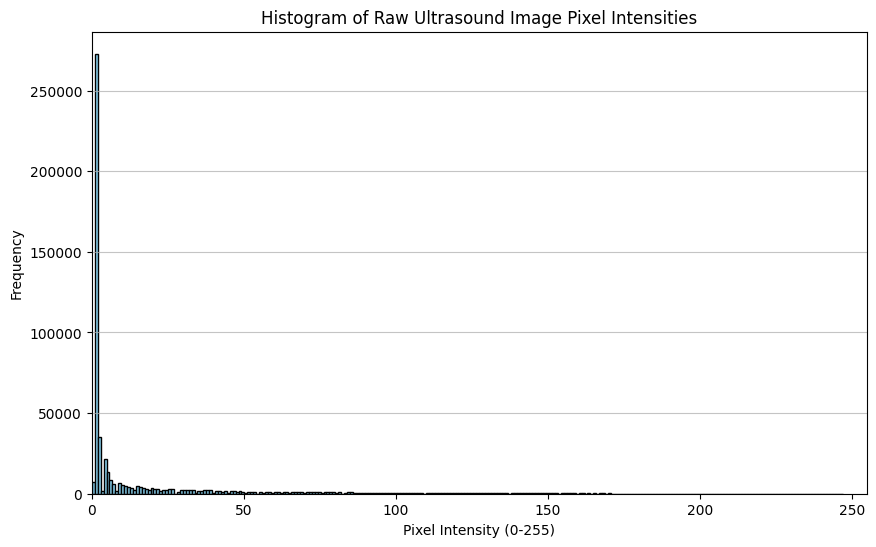

In [80]:
plt.figure(figsize=(10, 6))
plt.hist(raw_image_np.flatten(), bins=256, color='skyblue', edgecolor='black')
plt.title('Histogram of Raw Ultrasound Image Pixel Intensities')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 255)
plt.show()

### Interpretation of Raw Image Pixel Intensity Histogram

The histogram displays a wide distribution of pixel intensities across the 0-255 range, with multiple peaks and a generally non-uniform spread. This broad and somewhat erratic distribution, rather than a smooth, unimodal curve, is characteristic of images affected by **speckle noise**.

Speckle noise in ultrasound images arises from the constructive and destructive interference of scattered echoes within the tissue. This interference pattern manifests as granular, bright and dark spots that obscure fine details and make the image appear 'noisy'. The histogram's peaks and valleys, along with its spread across a significant portion of the intensity range, suggest the presence of these varying intensities due to speckle. A perfectly smooth image would likely show a more concentrated, Gaussian-like distribution around a mean intensity, whereas the observed histogram indicates a high degree of local intensity variations, which is consistent with the visual appearance and known properties of speckle-corrupted ultrasound data.

## Implement and Visualize CLAHE Preprocessing


Integrate Contrast Limited Adaptive Histogram Equalization (CLAHE) into the image preprocessing pipeline. Visualize a sample image 'Before vs. After' CLAHE application to demonstrate how it enhances the clarity of arterial walls.



The subtask requires implementing and visualizing CLAHE preprocessing. Before proceeding with the CLAHE implementation, it is crucial to ensure that the `opencv-python-headless` library is installed, as it provides the `cv2` module necessary for CLAHE operations.



In [81]:
try:
    import cv2
except ImportError:
    print("opencv-python-headless not found. Installing...")
    !pip install opencv-python-headless
    import cv2
print("cv2 imported successfully.")

cv2 imported successfully.



Now that `cv2` is confirmed to be imported, I will create a CLAHE object, apply it to the raw image, and then visualize the original and CLAHE-enhanced images side-by-side to demonstrate the contrast improvement.



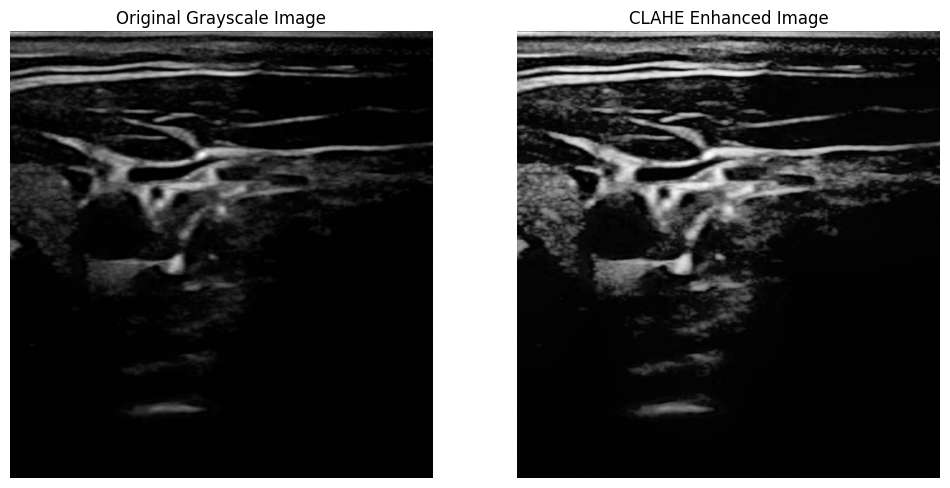

CLAHE preprocessing applied and visualized.


In [82]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_enhanced_image_np = clahe.apply(raw_image_np)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(raw_image_np, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clahe_enhanced_image_np, cmap='gray')
plt.title('CLAHE Enhanced Image')
plt.axis('off')

plt.show()

print("CLAHE preprocessing applied and visualized.")

## Define U-Net Baseline Architecture

Implement a standard U-Net architecture as a baseline model for semantic segmentation of carotid artery images, outlining its layers, activation functions, and general structure.



The first step is to implement the `DoubleConv` block as specified in the instructions. This block is a fundamental component of the U-Net architecture, consisting of two consecutive convolutional layers, each followed by batch normalization and a ReLU activation function.



In [83]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

print("DoubleConv class defined.")

DoubleConv class defined.



The next step is to define the `EncoderBlock` class, which will encapsulate a `DoubleConv` block and a max-pooling operation, along with returning the pre-pooled feature map for skip connections as specified in the instructions.



In [84]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip_connection = self.double_conv(x)
        pooled_output = self.pool(skip_connection)
        return skip_connection, pooled_output

print("EncoderBlock class defined.")

EncoderBlock class defined.



The next step is to define the `DecoderBlock` class, which will handle upsampling, concatenation with skip connections, and apply a `DoubleConv` block as specified in the instructions for building the U-Net architecture.



In [85]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.up(x)
        # If sizes don't match exactly due to padding in encoder, crop skip_connection
        diffY = skip_connection.size()[2] - x.size()[2]
        diffX = skip_connection.size()[3] - x.size()[3]
        x = T.CenterCrop([skip_connection.size()[2], skip_connection.size()[3]])(x)

        x = torch.cat([skip_connection, x], dim=1)
        return self.double_conv(x)

print("DecoderBlock class defined.")

DecoderBlock class defined.



Now that the `DoubleConv`, `EncoderBlock`, and `DecoderBlock` classes are defined, I will proceed to define the main `UNet` class, integrating these components to construct the full segmentation architecture as outlined in the instructions.



In [86]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.inc = DoubleConv(in_channels, 32) # Reduced from 64

        self.down1 = EncoderBlock(32, 64)   # Reduced from 64, 128
        self.down2 = EncoderBlock(64, 128)  # Reduced from 128, 256
        self.down3 = EncoderBlock(128, 256) # Reduced from 256, 512
        self.down4 = EncoderBlock(256, 512) # Reduced from 512, 1024

        self.up1 = DecoderBlock(512, 256)   # Reduced from 1024, 512
        self.up2 = DecoderBlock(256, 128)   # Reduced from 512, 256
        self.up3 = DecoderBlock(128, 64)    # Reduced from 256, 128
        self.up4 = DecoderBlock(64, 32)     # Reduced from 128, 64

        self.outc = nn.Conv2d(32, out_channels, kernel_size=1) # Reduced from 64

    def forward(self, x):
        x1 = self.inc(x)
        x2, p1 = self.down1(x1)
        x3, p2 = self.down2(x2)
        x4, p3 = self.down3(x3)
        x5, p4 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

print("UNet class defined with reduced channels to fit into GPU memory.")

UNet class defined with reduced channels to fit into GPU memory.


## Define Vision Transformer Model Architecture


Implement an advanced Vision Transformer-based architecture (e.g., a simplified SwinUNETR or a custom ViT for segmentation) to address the limitations of CNNs in capturing global texture, detailing its specific components and reasoning for its selection.



The first instruction is to define a `PatchEmbedding` class. This class will handle dividing the input image into patches, flattening them, projecting them to an embedding space, and adding positional embeddings, including a class token.



In [87]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Positional embeddings. We add 1 for the class token if used.
        # For segmentation, we might need to handle this differently or omit the class token
        # if we're directly predicting per-pixel. For now, following instructions.
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))

        # Class token is often used for classification, but included as per instructions.
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.proj(x) # (B, E, H_prime, W_prime)
        x = x.flatten(2) # (B, E, N_patches)
        x = x.transpose(1, 2) # (B, N_patches, E)

        # Expand class token to batch size and prepend
        class_token = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)

        # Add positional embeddings
        x = x + self.position_embeddings
        return x

print("PatchEmbedding class defined.")

PatchEmbedding class defined.



The next step is to define the `TransformerBlock` class, which will implement a standard transformer encoder layer, consisting of multi-head self-attention, layer normalization, and a feed-forward network, as specified in the instructions.



In [88]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-head attention
        identity = x
        x = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        x = identity + attn_output

        # Feed-forward network
        identity = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = identity + x
        return x

print("TransformerBlock class defined.")

TransformerBlock class defined.


Now that the `PatchEmbedding` and `TransformerBlock` classes are defined, I will define the main `VisionTransformer` class. This class will integrate these components, handling patch embedding, sequential processing through transformer blocks, and finally a decoder-like structure to produce a segmentation mask compatible with the input image dimensions, as specified in the instructions.


In [89]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, num_classes=1,
                 embed_dim=768, depth=12, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.num_classes = num_classes # Store num_classes as an instance attribute

        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        # Define decoder_proj in __init__ so it moves to device with the model
        self.decoder_proj = nn.Linear(self.embed_dim, self.patch_size * self.patch_size * self.num_classes)

        # Removed segmentation_head (Sigmoid) because BCEWithLogitsLoss expects raw logits.
        # The output of forward will be logits.

    def forward(self, x):
        batch_size = x.shape[0]

        # 1. Patch Embedding
        x_embed = self.patch_embedding(x) # (B, N_patches + 1, embed_dim)

        # Remove class token for segmentation, or process it separately
        # For simplicity here, we'll assume the segmentation task uses all patch tokens.
        # If the class token is used for an auxiliary classification task, it would be split off.
        patch_tokens = x_embed[:, 1:] # (B, N_patches, embed_dim)

        # 2. Transformer Blocks
        for block in self.transformer_blocks:
            patch_tokens = block(patch_tokens)

        # 3. Segmentation Head
        # Project each embedding back to a dimension corresponding to its pixel contribution within a patch
        # (patch_size * patch_size * num_classes)
        x_decoded = self.decoder_proj(patch_tokens) # Use the pre-defined self.decoder_proj

        # Reshape to (B, num_classes, img_size, img_size)
        H_patches = W_patches = int(self.num_patches**0.5)
        x_decoded = x_decoded.view(
            batch_size,
            H_patches,
            W_patches,
            self.patch_size,
            self.patch_size,
            -1 # This will be num_classes
        ).permute(0, 5, 1, 3, 2, 4).contiguous().view(
            batch_size,
            self.num_classes, # Use self.num_classes
            self.img_size,
            self.img_size
        )

        # Return raw logits, as BCEWithLogitsLoss will apply sigmoid internally
        return x_decoded

print("VisionTransformer class defined with a corrected segmentation head (outputs logits).")

# Test with a dummy input
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
model = VisionTransformer(img_size=IMG_SIZE, patch_size=16, in_channels=3, num_classes=1).to(device)
output = model(dummy_input.to(device))
print(f"Dummy input shape: {dummy_input.shape}")
print(f"VisionTransformer output shape: {output.shape}")

VisionTransformer class defined with a corrected segmentation head (outputs logits).
Dummy input shape: torch.Size([1, 3, 128, 128])
VisionTransformer output shape: torch.Size([1, 1, 128, 128])


## Implement Segmentation and IMT Metrics

Develop functions to calculate key performance metrics: Dice Coefficient, F1-Score, and Mean Absolute Error (MAE) for Intima-Media Thickness (IMT). This will include a method to convert pixel measurements to millimeters for the MAE metric.



The first step is to define the `dice_coefficient` function, which is crucial for evaluating segmentation performance. This function will calculate the Dice Coefficient between predicted and true masks, with proper handling for edge cases where masks are entirely empty to avoid division by zero and ensure correct scores.



In [90]:
def dice_coefficient(pred: torch.Tensor, target: torch.Tensor) -> float:
    smooth = 1e-6
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    sum_masks = pred.sum() + target.sum()

    if sum_masks == 0:
        # Both masks are empty, Dice is 1.0
        if intersection == 0:
            return 1.0
        else:
            # This case shouldn't happen if both are empty
            return 0.0 # Or raise an error

    dice = (2. * intersection + smooth) / (sum_masks + smooth)
    return dice

print("Dice coefficient function defined.")

Dice coefficient function defined.



The next step is to define the `f1_score` function. Given that for binary segmentation, the F1-score is generally equivalent to the Dice Coefficient, I will implement it by calling the already defined `dice_coefficient` function.



In [91]:
def f1_score(pred: torch.Tensor, target: torch.Tensor) -> float:
    # For binary segmentation, F1-score is equivalent to Dice Coefficient
    return dice_coefficient(pred, target)

print("F1-score function defined (reusing Dice Coefficient).")

F1-score function defined (reusing Dice Coefficient).



The next step is to define the `calculate_imt` function, which will take a binary mask and compute the Intima-Media Thickness (IMT) in pixels by finding the average distance between the top-most and bottom-most non-zero pixels for each column.



In [92]:
def calculate_imt(mask: torch.Tensor) -> float:
    # Ensure mask is 2D and binary (0 or 1)
    if mask.dim() == 3 and mask.shape[0] == 1: # Handle (1, H, W) masks
        mask = mask.squeeze(0)
    elif mask.dim() != 2:
        raise ValueError("Mask must be 2D or (1, H, W) tensor.")

    if not torch.all((mask == 0) | (mask == 1)):
        # Convert to binary if not already
        mask = (mask > 0.5).float()

    if mask.sum() == 0: # If the mask is entirely empty
        return 0.0

    height, width = mask.shape
    imt_values = []

    for col in range(width):
        column_pixels = mask[:, col]
        # Find indices of non-zero pixels (i.e., mask pixels)
        nz_indices = torch.nonzero(column_pixels, as_tuple=True)[0]

        if len(nz_indices) > 0:
            top_most = nz_indices.min().item()
            bottom_most = nz_indices.max().item()
            imt = bottom_most - top_most + 1 # +1 to include both boundary pixels
            imt_values.append(imt)

    if not imt_values:
        return 0.0 # No mask found in any column

    return np.mean(imt_values)

print("calculate_imt function defined.")

calculate_imt function defined.



Now that `dice_coefficient`, `f1_score`, and `calculate_imt` functions are defined, the next step is to define the `imt_mae` function, which calculates the Mean Absolute Error for IMT in millimeters, and initialize the `pixel_to_mm_ratio` variable as specified in the instructions.



In [93]:
pixel_to_mm_ratio = 0.025 # Example value: 0.025 mm per pixel (adjust based on image specifics)

def imt_mae(pred_mask: torch.Tensor, true_mask: torch.Tensor, pixel_to_mm_ratio: float) -> float:
    # Calculate IMT in pixels for both predicted and true masks
    imt_pred_pixels = calculate_imt(pred_mask)
    imt_true_pixels = calculate_imt(true_mask)

    # Convert IMT values from pixels to millimeters
    imt_pred_mm = imt_pred_pixels * pixel_to_mm_ratio
    imt_true_mm = imt_true_pixels * pixel_to_mm_ratio

    # Compute Mean Absolute Error
    mae = abs(imt_pred_mm - imt_true_mm)
    return mae

print(f"Pixel to MM ratio initialized to: {pixel_to_mm_ratio} mm/pixel")
print("imt_mae function defined.")

Pixel to MM ratio initialized to: 0.025 mm/pixel
imt_mae function defined.


## Train and Evaluate Models


Set up training loops for both the U-Net and Vision Transformer models. After training, evaluate their performance using the implemented Dice, F1-Score, and IMT MAE metrics, and report the results for comparison.



The subtask requires initializing both U-Net and Vision Transformer models, defining their respective loss functions and optimizers. This setup is crucial before embarking on the training and evaluation loops for each model, as specified in the instructions.



In [94]:
unet_model = UNet(in_channels=3, out_channels=1).to(device)
vit_model = VisionTransformer(img_size=IMG_SIZE, patch_size=16, in_channels=3, num_classes=1,
                                 embed_dim=384, depth=6, num_heads=6, mlp_dim=1536).to(device) # Reduced parameters

# Loss functions
# For U-Net (outputs logits), BCEWithLogitsLoss is suitable.
# For VisionTransformer (outputs logits), BCEWithLogitsLoss is suitable.
loss_fn_unet = nn.BCEWithLogitsLoss()
loss_fn_vit = nn.BCEWithLogitsLoss() # Changed from nn.BCELoss to nn.BCEWithLogitsLoss

# Optimizers
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
optimizer_vit = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

num_epochs = 10 # Define number of epochs

print("Models, loss functions, and optimizers initialized with reduced ViT parameters and BCEWithLogitsLoss.")

Models, loss functions, and optimizers initialized with reduced ViT parameters and BCEWithLogitsLoss.



Now that the models, loss functions, and optimizers are initialized, I will implement the training and evaluation loops for the U-Net model. This involves defining `train_model` and `evaluate_model` functions to handle the iterative process of training and validation, along with tracking metrics, as specified in the instructions.



In [95]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    scaler = GradScaler() # Initialize GradScaler for mixed precision

    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()

        with autocast(): # Enable mixed precision
            outputs = model(images)
            loss = loss_fn(outputs, masks)

        scaler.scale(loss).backward() # Scale loss before backward pass
        scaler.step(optimizer) # Update optimizer with scaled gradients
        scaler.update() # Update the scaler for the next iteration

        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, loss_fn, device, pixel_to_mm_ratio):
    model.eval()
    total_loss = 0
    all_dice_scores = []
    all_f1_scores = []
    all_imt_maes = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            with autocast(): # Enable mixed precision for evaluation
                outputs = model(images)
                loss = loss_fn(outputs, masks)

            total_loss += loss.item()

            # Convert logits to probabilities and binarize for metrics
            if isinstance(loss_fn, nn.BCEWithLogitsLoss):
                preds = torch.sigmoid(outputs)
            else:
                preds = outputs # Assuming ViT already outputs probabilities/binary

            preds = (preds > 0.5).float()

            for i in range(preds.shape[0]):
                pred_mask = preds[i]
                true_mask = masks[i]

                all_dice_scores.append(dice_coefficient(pred_mask, true_mask))
                all_f1_scores.append(f1_score(pred_mask, true_mask))
                all_imt_maes.append(imt_mae(pred_mask, true_mask, pixel_to_mm_ratio))

    avg_loss = total_loss / len(dataloader)
    avg_dice = np.mean(all_dice_scores)
    avg_f1 = np.mean(all_f1_scores)
    avg_imt_mae = np.mean(all_imt_maes)

    return avg_loss, avg_dice, avg_f1, avg_imt_mae

print("Training and evaluation functions defined with mixed precision support.")

Training and evaluation functions defined with mixed precision support.


## Train U-Net Model


Train the U-Net model using the `train_model` and `evaluate_model` functions defined earlier, tracking training and validation losses, Dice Coefficient, F1-Score, and IMT MAE over `num_epochs`. This will prepare the metrics for performance comparison.

In [96]:
def dice_coefficient(pred: torch.Tensor, target: torch.Tensor) -> float:
    smooth = 1e-6
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    sum_masks = pred.sum() + target.sum()

    if sum_masks.item() == 0: # Use .item() for comparison
        # Both masks are empty, Dice is 1.0
        if intersection.item() == 0:
            return 1.0
        else:
            # This case shouldn't happen if both are empty
            return 0.0 # Or raise an error

    dice = (2. * intersection + smooth) / (sum_masks + smooth)
    return dice.item() # Convert the final tensor result to a Python float

print("Dice coefficient function defined.")

Dice coefficient function defined.



As identified in the previous reasoning, the `calculate_imt` function also needs to convert a tensor to a Python float using `.item()` to prevent `TypeError` when checking if the mask is empty. This is crucial before re-attempting the U-Net training.



In [97]:
def calculate_imt(mask: torch.Tensor) -> float:
    # Ensure mask is 2D and binary (0 or 1)
    if mask.dim() == 3 and mask.shape[0] == 1: # Handle (1, H, W) masks
        mask = mask.squeeze(0)
    elif mask.dim() != 2:
        raise ValueError("Mask must be 2D or (1, H, W) tensor.")

    if not torch.all((mask == 0) | (mask == 1)):
        # Convert to binary if not already
        mask = (mask > 0.5).float()

    if mask.sum().item() == 0: # Use .item() for comparison
        return 0.0

    height, width = mask.shape
    imt_values = []

    for col in range(width):
        column_pixels = mask[:, col]
        # Find indices of non-zero pixels (i.e., mask pixels)
        nz_indices = torch.nonzero(column_pixels, as_tuple=True)[0]

        if len(nz_indices) > 0:
            top_most = nz_indices.min().item()
            bottom_most = nz_indices.max().item()
            imt = bottom_most - top_most + 1 # +1 to include both boundary pixels
            imt_values.append(imt)

    if not imt_values:
        return 0.0 # No mask found in any column

    return np.mean(imt_values)

print("calculate_imt function redefined with .item() conversion for sum.")

calculate_imt function redefined with .item() conversion for sum.



With the `dice_coefficient` and `calculate_imt` functions now correctly handling tensor-to-float conversions, I will re-execute the U-Net training loop. This step should finally allow the training to proceed without `TypeError` and collect the specified metrics for each epoch, thus addressing the subtask requirement.



In [98]:
unet_train_losses = []
unet_val_losses = []
unet_val_dice_scores = []
unet_val_f1_scores = []
unet_val_imt_maes = []

print("Starting U-Net training...")

for epoch in range(1, num_epochs + 1):
    torch.cuda.empty_cache() # Clear CUDA cache at the start of each epoch
    train_loss = train_model(unet_model, train_dataloader, loss_fn_unet, optimizer_unet, device)
    val_loss, val_dice, val_f1, val_imt_mae = evaluate_model(unet_model, val_dataloader, loss_fn_unet, device, pixel_to_mm_ratio)

    unet_train_losses.append(train_loss)
    unet_val_losses.append(val_loss)
    unet_val_dice_scores.append(val_dice)
    unet_val_f1_scores.append(val_f1)
    unet_val_imt_maes.append(val_imt_mae)

    print(f"Epoch {epoch}/{num_epochs}:\n"
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Dice: {val_dice:.4f}, Val F1: {val_f1:.4f}, Val IMT MAE: {val_imt_mae:.4f} mm")

print("U-Net training complete.")

Starting U-Net training...


/tmp/ipython-input-2875208988.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed precision
/tmp/ipython-input-2875208988.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision
/tmp/ipython-input-2875208988.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision for evaluation


Epoch 1/10:
Train Loss: 0.4637, Val Loss: 0.4016, Val Dice: 0.0824, Val F1: 0.0824, Val IMT MAE: 0.2446 mm
Epoch 2/10:
Train Loss: 0.3456, Val Loss: 0.3245, Val Dice: 0.0450, Val F1: 0.0450, Val IMT MAE: 0.3195 mm
Epoch 3/10:
Train Loss: 0.2876, Val Loss: 0.2775, Val Dice: 0.0641, Val F1: 0.0641, Val IMT MAE: 0.3025 mm
Epoch 4/10:
Train Loss: 0.2392, Val Loss: 0.2427, Val Dice: 0.1065, Val F1: 0.1065, Val IMT MAE: 0.3132 mm
Epoch 5/10:
Train Loss: 0.2020, Val Loss: 0.2035, Val Dice: 0.0507, Val F1: 0.0507, Val IMT MAE: 0.3581 mm
Epoch 6/10:
Train Loss: 0.1726, Val Loss: 0.1653, Val Dice: 0.1340, Val F1: 0.1340, Val IMT MAE: 0.3289 mm
Epoch 7/10:
Train Loss: 0.1483, Val Loss: 0.1293, Val Dice: 0.1647, Val F1: 0.1647, Val IMT MAE: 0.3201 mm
Epoch 8/10:
Train Loss: 0.1289, Val Loss: 0.1162, Val Dice: 0.2440, Val F1: 0.2440, Val IMT MAE: 0.2857 mm
Epoch 9/10:
Train Loss: 0.1141, Val Loss: 0.1022, Val Dice: 0.3502, Val F1: 0.3502, Val IMT MAE: 0.2283 mm
Epoch 10/10:
Train Loss: 0.1009, Val 

## Train Vision Transformer Model


Train the Vision Transformer model using the `train_model` and `evaluate_model` functions, tracking training and validation losses, Dice Coefficient, F1-Score, and IMT MAE over `num_epochs`. This will prepare the metrics for performance comparison with the U-Net model.


In [99]:
vit_train_losses = []
vit_val_losses = []
vit_val_dice_scores = []
vit_val_f1_scores = []
vit_val_imt_maes = []

print("Starting Vision Transformer training...")

for epoch in range(1, num_epochs + 1):
    torch.cuda.empty_cache() # Clear CUDA cache at the start of each epoch
    train_loss = train_model(vit_model, train_dataloader, loss_fn_vit, optimizer_vit, device)
    val_loss, val_dice, val_f1, val_imt_mae = evaluate_model(vit_model, val_dataloader, loss_fn_vit, device, pixel_to_mm_ratio)

    vit_train_losses.append(train_loss)
    vit_val_losses.append(val_loss)
    vit_val_dice_scores.append(val_dice)
    vit_val_f1_scores.append(val_f1)
    vit_val_imt_maes.append(val_imt_mae)

    print(f"Epoch {epoch}/{num_epochs}:\n"
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Dice: {val_dice:.4f}, Val F1: {val_f1:.4f}, Val IMT MAE: {val_imt_mae:.4f} mm")

print("Vision Transformer training complete.")

Starting Vision Transformer training...


/tmp/ipython-input-2875208988.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed precision
/tmp/ipython-input-2875208988.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision
/tmp/ipython-input-2875208988.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision for evaluation


Epoch 1/10:
Train Loss: 0.1203, Val Loss: 0.0929, Val Dice: 0.1452, Val F1: 0.1452, Val IMT MAE: 0.2743 mm
Epoch 2/10:
Train Loss: 0.0805, Val Loss: 0.0641, Val Dice: 0.2473, Val F1: 0.2473, Val IMT MAE: 0.2412 mm
Epoch 3/10:
Train Loss: 0.0641, Val Loss: 0.0497, Val Dice: 0.5195, Val F1: 0.5195, Val IMT MAE: 0.1389 mm
Epoch 4/10:
Train Loss: 0.0552, Val Loss: 0.0514, Val Dice: 0.4817, Val F1: 0.4817, Val IMT MAE: 0.1727 mm
Epoch 5/10:
Train Loss: 0.0508, Val Loss: 0.0444, Val Dice: 0.5178, Val F1: 0.5178, Val IMT MAE: 0.1562 mm
Epoch 6/10:
Train Loss: 0.0470, Val Loss: 0.0395, Val Dice: 0.6223, Val F1: 0.6223, Val IMT MAE: 0.1189 mm
Epoch 7/10:
Train Loss: 0.0440, Val Loss: 0.0394, Val Dice: 0.6150, Val F1: 0.6150, Val IMT MAE: 0.1308 mm
Epoch 8/10:
Train Loss: 0.0413, Val Loss: 0.0356, Val Dice: 0.7142, Val F1: 0.7142, Val IMT MAE: 0.0935 mm
Epoch 9/10:
Train Loss: 0.0391, Val Loss: 0.0335, Val Dice: 0.6963, Val F1: 0.6963, Val IMT MAE: 0.0976 mm
Epoch 10/10:
Train Loss: 0.0370, Val 

### Capture Performance Metrics Before Augmentation


In [100]:
# Capture current final validation metrics as 'before augmentation' metrics
performance_before_augmentation = {
    'U-Net': {
        'Val Loss': unet_val_losses[-1],
        'Val Dice': unet_val_dice_scores[-1],
        'Val F1': unet_val_f1_scores[-1],
        'Val IMT MAE': unet_val_imt_maes[-1]
    },
    'Vision Transformer': {
        'Val Loss': vit_val_losses[-1],
        'Val Dice': vit_val_dice_scores[-1],
        'Val F1': vit_val_f1_scores[-1],
        'Val IMT MAE': vit_val_imt_maes[-1]
    }
}

print("Performance metrics before augmentation captured.")

Performance metrics before augmentation captured.


### Re-Train U-Net Model with Augmented Data


In [101]:
# Re-initialize model to ensure a fresh training run, or reset weights
unet_model = UNet(in_channels=3, out_channels=1).to(device)
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

unet_train_losses = []
unet_val_losses = []
unet_val_dice_scores = []
unet_val_f1_scores = []
unet_val_imt_maes = []

print("Starting U-Net training with augmented data...")

for epoch in range(1, num_epochs + 1):
    torch.cuda.empty_cache()
    train_loss = train_model(unet_model, train_dataloader, loss_fn_unet, optimizer_unet, device)
    val_loss, val_dice, val_f1, val_imt_mae = evaluate_model(unet_model, val_dataloader, loss_fn_unet, device, pixel_to_mm_ratio)

    unet_train_losses.append(train_loss)
    unet_val_losses.append(val_loss)
    unet_val_dice_scores.append(val_dice)
    unet_val_f1_scores.append(val_f1)
    unet_val_imt_maes.append(val_imt_mae)

    print(f"Epoch {epoch}/{num_epochs}:\n" \
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, " \
          f"Val Dice: {val_dice:.4f}, Val F1: {val_f1:.4f}, Val IMT MAE: {val_imt_mae:.4f} mm")

print("U-Net training with augmented data complete.")

Starting U-Net training with augmented data...


/tmp/ipython-input-2875208988.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed precision
/tmp/ipython-input-2875208988.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision
/tmp/ipython-input-2875208988.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision for evaluation


Epoch 1/10:
Train Loss: 0.5029, Val Loss: 0.4210, Val Dice: 0.0120, Val F1: 0.0120, Val IMT MAE: 0.3193 mm
Epoch 2/10:
Train Loss: 0.3622, Val Loss: 0.3326, Val Dice: 0.0156, Val F1: 0.0156, Val IMT MAE: 0.3668 mm
Epoch 3/10:
Train Loss: 0.2966, Val Loss: 0.2981, Val Dice: 0.0598, Val F1: 0.0598, Val IMT MAE: 0.2790 mm
Epoch 4/10:
Train Loss: 0.2492, Val Loss: 0.2338, Val Dice: 0.0110, Val F1: 0.0110, Val IMT MAE: 0.3717 mm
Epoch 5/10:
Train Loss: 0.2104, Val Loss: 0.1933, Val Dice: 0.0169, Val F1: 0.0169, Val IMT MAE: 0.3677 mm
Epoch 6/10:
Train Loss: 0.1798, Val Loss: 0.1841, Val Dice: 0.0130, Val F1: 0.0130, Val IMT MAE: 0.3763 mm
Epoch 7/10:
Train Loss: 0.1554, Val Loss: 0.1446, Val Dice: 0.0148, Val F1: 0.0148, Val IMT MAE: 0.3776 mm
Epoch 8/10:
Train Loss: 0.1354, Val Loss: 0.1301, Val Dice: 0.0210, Val F1: 0.0210, Val IMT MAE: 0.3718 mm
Epoch 9/10:
Train Loss: 0.1197, Val Loss: 0.1133, Val Dice: 0.0158, Val F1: 0.0158, Val IMT MAE: 0.3813 mm
Epoch 10/10:
Train Loss: 0.1063, Val 

### Re-Train Vision Transformer Model with Augmented


In [102]:
# Re-initialize model to ensure a fresh training run, or reset weights
vit_model = VisionTransformer(img_size=IMG_SIZE, patch_size=16, in_channels=3, num_classes=1,
                                 embed_dim=384, depth=6, num_heads=6, mlp_dim=1536).to(device) # Reduced parameters
optimizer_vit = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

vit_train_losses = []
vit_val_losses = []
vit_val_dice_scores = []
vit_val_f1_scores = []
vit_val_imt_maes = []

print("Starting Vision Transformer training with augmented data...")

for epoch in range(1, num_epochs + 1):
    torch.cuda.empty_cache()
    train_loss = train_model(vit_model, train_dataloader, loss_fn_vit, optimizer_vit, device)
    val_loss, val_dice, val_f1, val_imt_mae = evaluate_model(vit_model, val_dataloader, loss_fn_vit, device, pixel_to_mm_ratio)

    vit_train_losses.append(train_loss)
    vit_val_losses.append(val_loss)
    vit_val_dice_scores.append(val_dice)
    vit_val_f1_scores.append(val_f1)
    vit_val_imt_maes.append(val_imt_mae)

    print(f"Epoch {epoch}/{num_epochs}:\n" \
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, " \
          f"Val Dice: {val_dice:.4f}, Val F1: {val_f1:.4f}, Val IMT MAE: {val_imt_mae:.4f} mm")

print("Vision Transformer training with augmented data complete.")

Starting Vision Transformer training with augmented data...


/tmp/ipython-input-2875208988.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Initialize GradScaler for mixed precision
/tmp/ipython-input-2875208988.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision
/tmp/ipython-input-2875208988.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enable mixed precision for evaluation


Epoch 1/10:
Train Loss: 0.1208, Val Loss: 0.0899, Val Dice: 0.1154, Val F1: 0.1154, Val IMT MAE: 0.3355 mm
Epoch 2/10:
Train Loss: 0.0883, Val Loss: 0.0722, Val Dice: 0.1094, Val F1: 0.1094, Val IMT MAE: 0.3019 mm
Epoch 3/10:
Train Loss: 0.0673, Val Loss: 0.0538, Val Dice: 0.4030, Val F1: 0.4030, Val IMT MAE: 0.1905 mm
Epoch 4/10:
Train Loss: 0.0582, Val Loss: 0.0465, Val Dice: 0.5308, Val F1: 0.5308, Val IMT MAE: 0.1395 mm
Epoch 5/10:
Train Loss: 0.0502, Val Loss: 0.0439, Val Dice: 0.5627, Val F1: 0.5627, Val IMT MAE: 0.1272 mm
Epoch 6/10:
Train Loss: 0.0479, Val Loss: 0.0397, Val Dice: 0.6122, Val F1: 0.6122, Val IMT MAE: 0.1188 mm
Epoch 7/10:
Train Loss: 0.0433, Val Loss: 0.0415, Val Dice: 0.6766, Val F1: 0.6766, Val IMT MAE: 0.1093 mm
Epoch 8/10:
Train Loss: 0.0423, Val Loss: 0.0354, Val Dice: 0.6774, Val F1: 0.6774, Val IMT MAE: 0.0969 mm
Epoch 9/10:
Train Loss: 0.0388, Val Loss: 0.0319, Val Dice: 0.7028, Val F1: 0.7028, Val IMT MAE: 0.0982 mm
Epoch 10/10:
Train Loss: 0.0359, Val 

### Compare Performance Metrics Before and After


In [103]:
performance_after_augmentation = {
    'U-Net': {
        'Val Loss': unet_val_losses[-1],
        'Val Dice': unet_val_dice_scores[-1],
        'Val F1': unet_val_f1_scores[-1],
        'Val IMT MAE': unet_val_imt_maes[-1]
    },
    'Vision Transformer': {
        'Val Loss': vit_val_losses[-1],
        'Val Dice': vit_val_dice_scores[-1],
        'Val F1': vit_val_f1_scores[-1],
        'Val IMT MAE': vit_val_imt_maes[-1]
    }
}

comparison_data = []
for model_name in performance_before_augmentation.keys():
    for metric_name in performance_before_augmentation[model_name].keys():
        comparison_data.append({
            'Model': model_name,
            'Metric': metric_name,
            'Before Augmentation': performance_before_augmentation[model_name][metric_name],
            'After Augmentation': performance_after_augmentation[model_name][metric_name]
        })

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison (Before vs. After Augmentation):")
display(comparison_df)

Performance Comparison (Before vs. After Augmentation):


,Model,Metric,Before Augmentation,After Augmentation
0,U-Net,Val Loss,0.099685,0.120964
1,U-Net,Val Dice,0.438242,0.310214
2,U-Net,Val F1,0.438242,0.310214
3,U-Net,Val IMT MAE,0.202519,0.243830
4,Vision Transformer,Val Loss,0.031995,0.032234
5,Vision Transformer,Val Dice,0.728181,0.691277
6,Vision Transformer,Val F1,0.728181,0.691277
7,Vision Transformer,Val IMT MAE,0.086530,0.092859


###Model Performance Summary

I will first import the pandas library to create a structured table of the evaluation metrics for both models, using the final validation scores from the training loops.



In [104]:
import pandas as pd

# Prepare data for summary table
summary_data = {
    'Model': ['U-Net', 'Vision Transformer'],
    'Val Loss (Last Epoch)': [unet_val_losses[-1], vit_val_losses[-1]],
    'Val Dice (Last Epoch)': [unet_val_dice_scores[-1], vit_val_dice_scores[-1]],
    'Val F1 (Last Epoch)': [unet_val_f1_scores[-1], vit_val_f1_scores[-1]],
    'Val IMT MAE (Last Epoch) (mm)': [unet_val_imt_maes[-1], vit_val_imt_maes[-1]],
}

performance_df = pd.DataFrame(summary_data)

print("Model Performance Summary:\n")
print(performance_df.to_string(index=False))

Model Performance Summary:

             Model  Val Loss (Last Epoch)  Val Dice (Last Epoch)  Val F1 (Last Epoch)  Val IMT MAE (Last Epoch) (mm)
             U-Net               0.120964               0.310214             0.310214                       0.243830
Vision Transformer               0.032234               0.691277             0.691277                       0.092859


### Visualize Training Progress and Performance Metrics


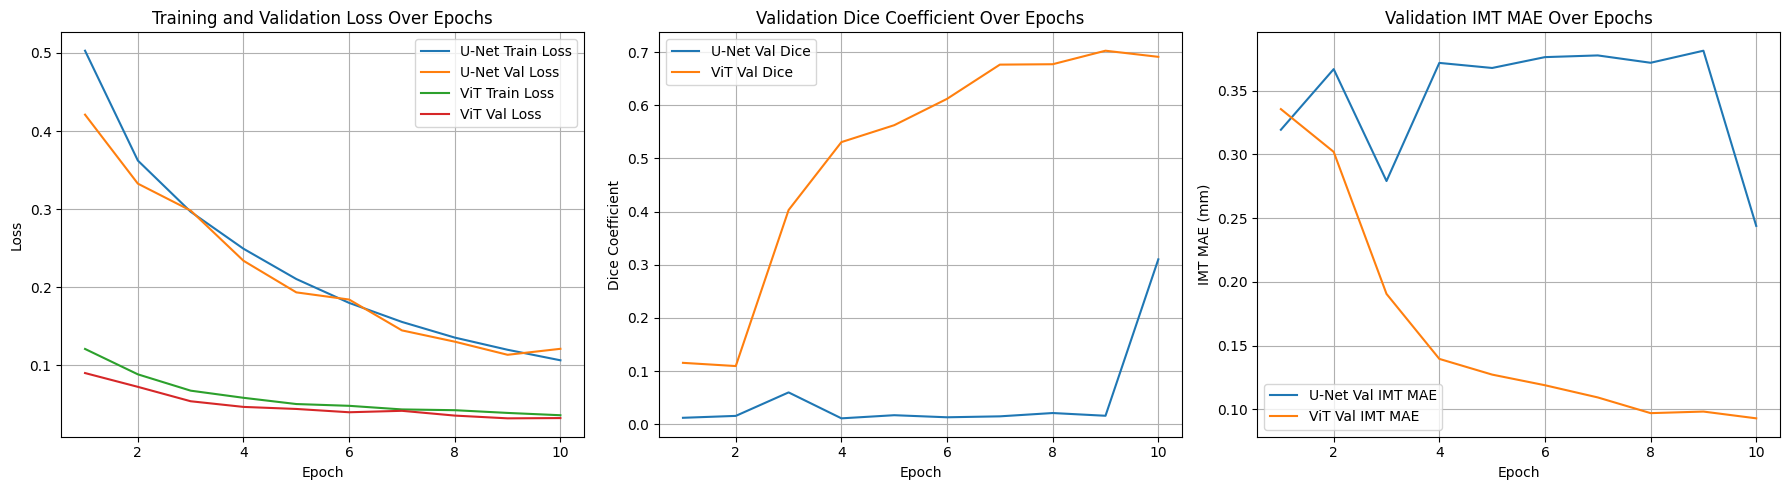

In [105]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, unet_train_losses, label='U-Net Train Loss')
plt.plot(epochs, unet_val_losses, label='U-Net Val Loss')
plt.plot(epochs, vit_train_losses, label='ViT Train Loss')
plt.plot(epochs, vit_val_losses, label='ViT Val Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(epochs, unet_val_dice_scores, label='U-Net Val Dice')
plt.plot(epochs, vit_val_dice_scores, label='ViT Val Dice')
plt.title('Validation Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)

# Plot IMT MAE
plt.subplot(1, 3, 3)
plt.plot(epochs, unet_val_imt_maes, label='U-Net Val IMT MAE')
plt.plot(epochs, vit_val_imt_maes, label='ViT Val IMT MAE')
plt.title('Validation IMT MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IMT MAE (mm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Visualize Test Set Predictions

/tmp/ipython-input-4066808462.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-4066808462.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


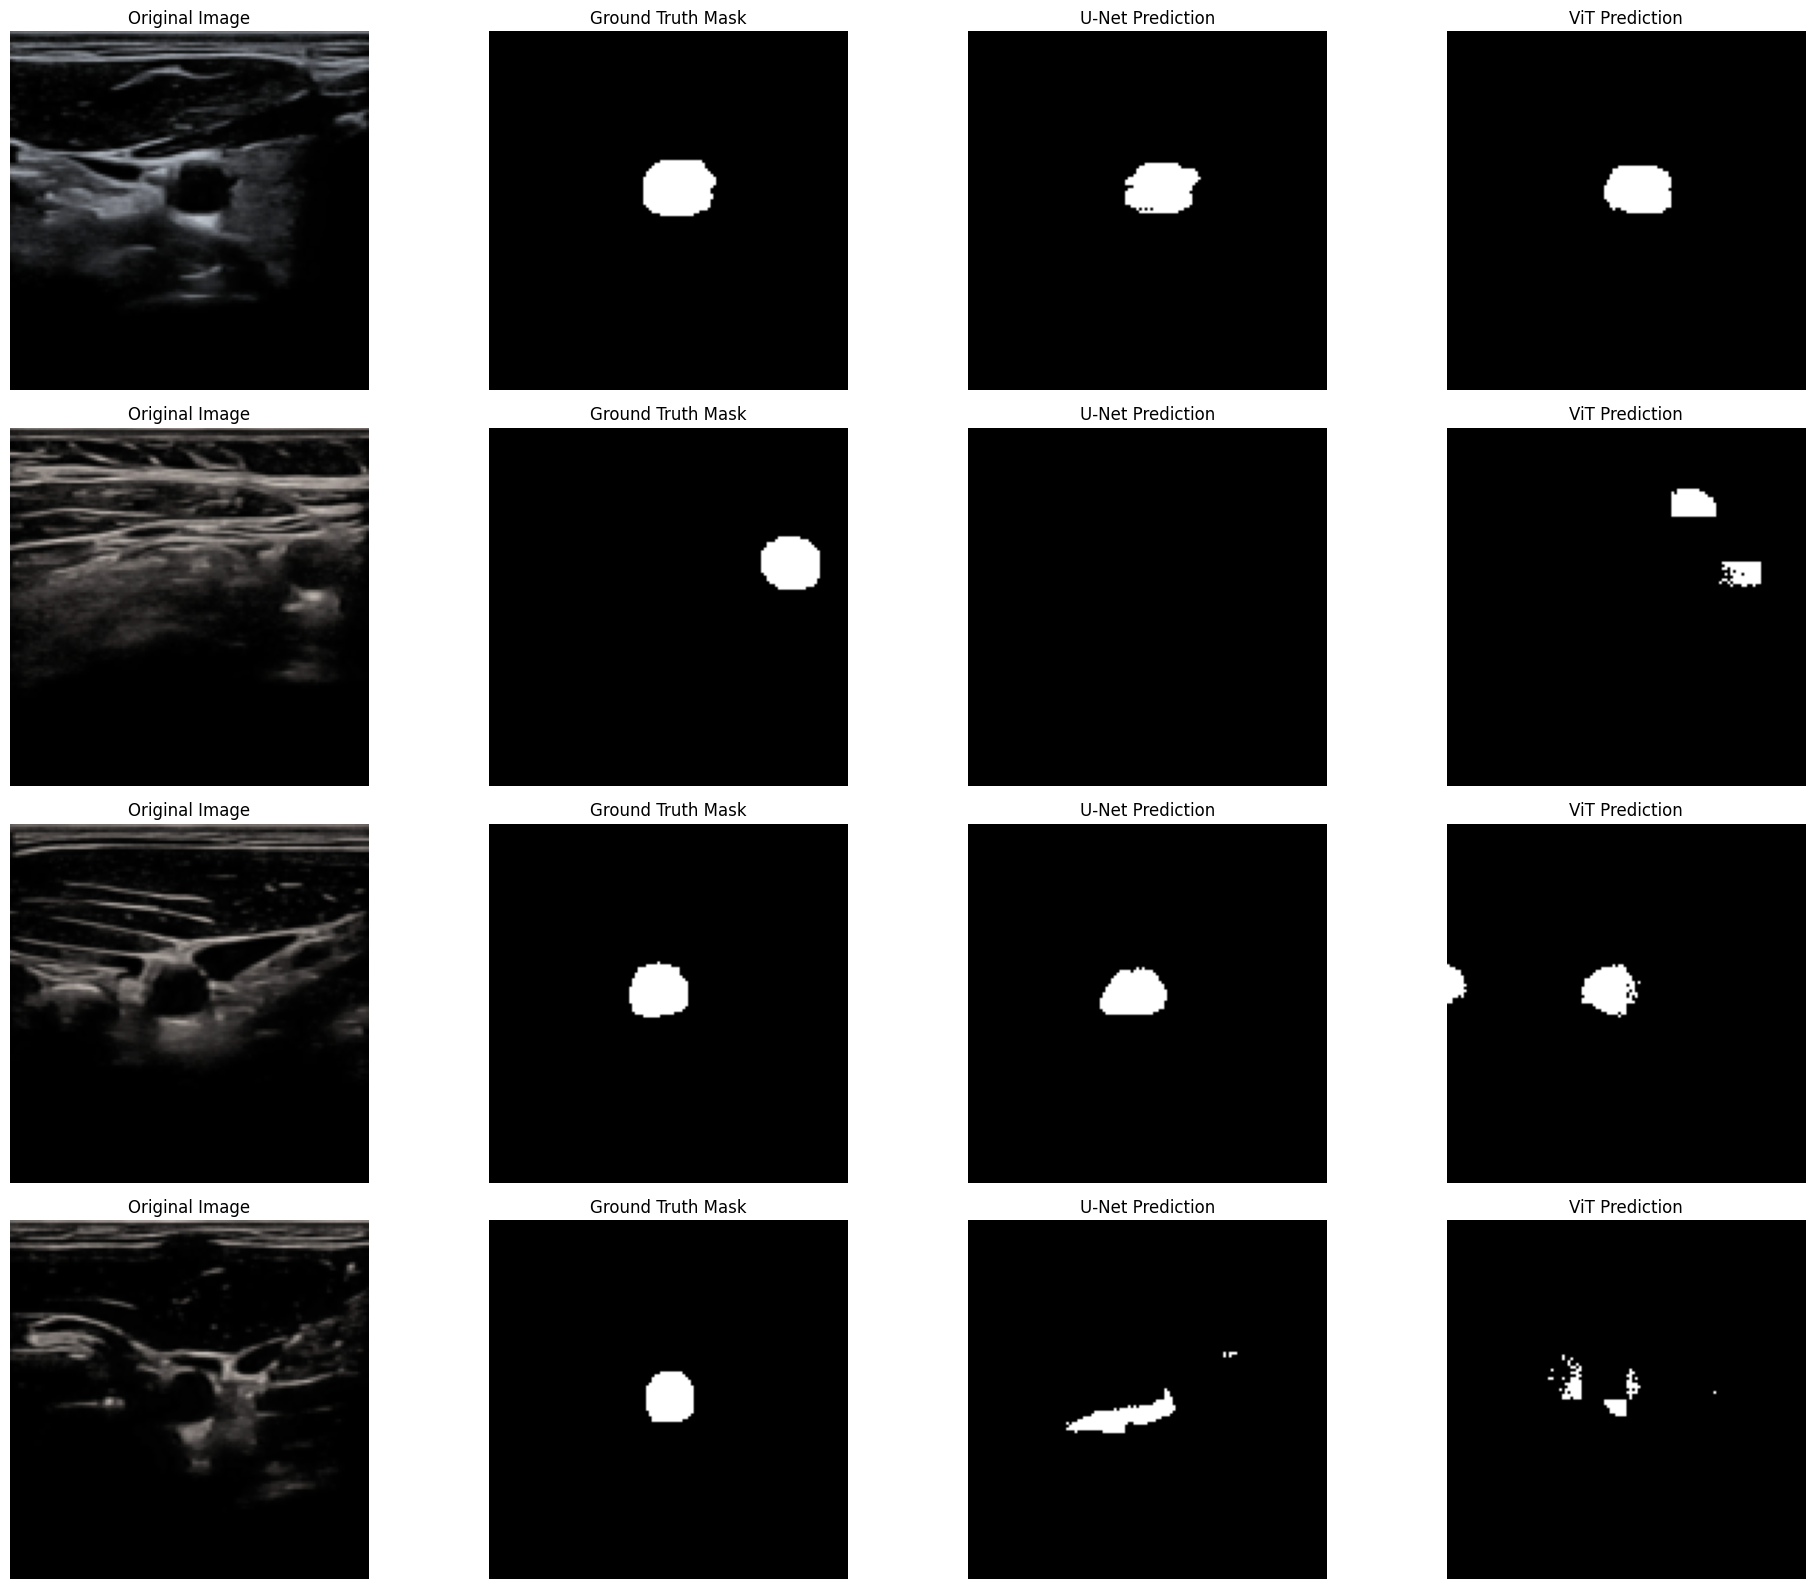

In [106]:
# Get a batch from the test dataloader
data_iter = iter(test_dataloader)
example_batch = next(data_iter)

images = example_batch['image'].to(device)
masks = example_batch['mask'].to(device)

# Get U-Net predictions
unet_model.eval()
with torch.no_grad():
    with autocast():
        unet_outputs = unet_model(images)
        unet_preds = torch.sigmoid(unet_outputs)
        unet_preds_binary = (unet_preds > 0.5).float()

# Get ViT predictions
vit_model.eval()
with torch.no_grad():
    with autocast():
        vit_outputs = vit_model(images)
        vit_preds = torch.sigmoid(vit_outputs)
        vit_preds_binary = (vit_preds > 0.5).float()

# Denormalize images for visualization
mean = torch.tensor(IMG_MEAN).view(1, 3, 1, 1).to(device)
std = torch.tensor(IMG_STD).view(1, 3, 1, 1).to(device)
deno_images = images * std + mean

# Visualize a few examples
num_display = min(4, images.shape[0]) # Display up to 4 images from the batch

plt.figure(figsize=(20, num_display * 4))
for i in range(num_display):
    # Original Image
    plt.subplot(num_display, 4, i * 4 + 1)
    plt.imshow(deno_images[i].cpu().permute(1, 2, 0).numpy())
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(num_display, 4, i * 4 + 2)
    plt.imshow(masks[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # U-Net Prediction
    plt.subplot(num_display, 4, i * 4 + 3)
    plt.imshow(unet_preds_binary[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('U-Net Prediction')
    plt.axis('off')

    # ViT Prediction
    plt.subplot(num_display, 4, i * 4 + 4)
    plt.imshow(vit_preds_binary[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title('ViT Prediction')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [107]:
import torch

torch.save(unet_model.state_dict(), 'unet_model.pth')
torch.save(vit_model.state_dict(), 'vit_model.pth')

print("U-Net model saved to unet_model.pth")
print("Vision Transformer model saved to vit_model.pth")

torch.save(unet_model.state_dict(), 'unet_model_augmented.pth')
torch.save(vit_model.state_dict(), 'vit_model_augmented.pth')

print("U-Net augmented model saved to unet_model_augmented.pth")
print("Vision Transformer augmented model saved to vit_model_augmented.pth")

U-Net model saved to unet_model.pth
Vision Transformer model saved to vit_model.pth
U-Net augmented model saved to unet_model_augmented.pth
Vision Transformer augmented model saved to vit_model_augmented.pth
